In [1]:
import numpy as np
from scipy.sparse import csr_matrix, find
from scipy.spatial import cKDTree
from tqdm import tqdm_notebook as tqdm
from datasets.graph import draw_sample
import torch
import glob

In [2]:
flist = [filepath for filepath in glob.iglob(r'/home/sameasy2006/npzpion_k6/pion_hfntup_0to1000/processed/data_*.pt')]
flist = flist[16128:16628]  

In [3]:
model_fname = '/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/output_pion6nn/checkpoints/model_checkpoint_EdgeNet2_21858_db062f87e7_sameasy2006.best.pth.tar'
from models.EdgeNet2 import EdgeNet2
mdl = EdgeNet2(input_dim=5, hidden_dim=64, output_dim=1, n_iters=6)
mdl.load_state_dict(torch.load(model_fname, map_location=torch.device('cpu'))['model'])
mdl.eval()

EdgeNet2(
  (inputnet): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (edgenetwork): Sequential(
    (0): Linear(in_features=778, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (nodenetwork): EdgeConv(nn=Sequential(
    (0): Linear(in_features=138, out_features=101, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=101, out_features=64, bias=True)
    (4): ReLU()
  ))
)

In [4]:
def energy(X,Ro,mask):
    Ro = Ro[mask]
    # Select the i/o node features for each segment    
#    feats_o = X[Ro]
    feats_o = X[np.unique(Ro)]
    return feats_o[:,4].sum()

In [5]:


r_tot_predE = []
r_corr_predE = []
for filename in tqdm(flist):
    data = torch.load(filename)
    X = data.x.detach().numpy()
    pred_edges = mdl(data).detach()
    pred_edges_np = pred_edges.numpy()
    index = data.edge_index.numpy().T
    Ro = index[:,0]
    Ri = index[:,1]
    y = data.y.numpy()
    out =pred_edges_np
    
    truth_mask = y > 0.5
    truth_energy = energy(X,Ro,truth_mask)
    pred_mask = out > 0.5
    pred_energy = energy(X,Ro,pred_mask)
    corr_pred_mask = (out >0.5) & (y > 0.5)
    corr_pred_energy = energy(X,Ro,corr_pred_mask)

    r_tot_predE.append(pred_energy/truth_energy)
    r_corr_predE.append(corr_pred_energy/truth_energy)
    if (corr_pred_energy/truth_energy == 1):
        print (corr_pred_energy,truth_energy,pred_energy)
    
    

/home/sameasy2006/miniconda3/envs/mlgnn/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


186.35976 186.35976 186.52115
38.264374 38.264374 38.264374
2.092295 2.092295 2.092295
0.91378415 0.91378415 0.91378415
275.13422 275.13422 275.23227
63.215637 63.215637 63.255367
72.0312 72.0312 72.05354
106.10341 106.10341 106.10341
18.967037 18.967037 18.967037
74.66461 74.66461 74.6976
0.6350529 0.6350529 0.8237568
6.352644 6.352644 6.352644
0.46965936 0.46965936 0.46965936
0.98082757 0.98082757 1.0131084
0.54404724 0.54404724 0.57881117
2.1617389 2.1617389 2.1617389
0.66460896 0.66460896 0.70682234
1.5578952 1.5578952 1.5578952
30.95471 30.95471 30.95471
4.356385 4.356385 4.356385
2.9919102 2.9919102 2.9919102
354.10034 354.10034 354.15222
317.62918 317.62918 317.73294
0.44230264 0.44230264 0.44230264
142.07767 142.07767 142.07767
72.17928 72.17928 72.29457
0.41268545 0.41268545 0.41268545
0.5298237 0.5298237 0.5298237
19.718502 19.718502 19.781904
0.50971997 0.50971997 0.50971997
48.140583 48.140583 48.19246
4.061947 4.061947 4.061947
0.39954638 0.39954638 0.39954638
2.01413 2.01

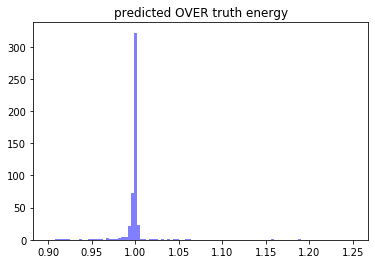

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
mu, sigma = (np.mean(r_tot_predE), np.std(r_tot_predE))
plt.hist(r_tot_predE, bins=100,range=[0.9,1.25],color='blue', alpha=0.5)
plt.title('predicted OVER truth energy')
plt.show()

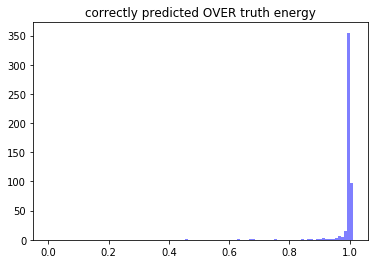

In [21]:

mu, sigma = (np.mean(r_corr_predE), np.std(r_corr_predE))
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
#    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))

#print (mu,sigma)
plt.hist(r_corr_predE, bins=100,range=[0.,1.01],color='blue', alpha=0.5)
plt.title('correctly predicted OVER truth energy')
#plt.text(0.05, 0.95, textstr,  fontsize=14,verticalalignment='top')    
#plt.yscale('log')
plt.show()

In [8]:
print((np.array(r_corr_predE) > 0.9).sum()/(len(r_corr_predE)))

0.978


In [9]:
test_fname = '/home/sameasy2006/npzpion_k6/pion_hfntup_0to1000/processed/data_1809.pt'
data = torch.load(test_fname)
X = data.x.detach().numpy()
pred_edges = mdl(data).detach()
pred_edges_np = pred_edges.numpy()
index = data.edge_index.numpy().T
Ro = index[:,0]
Ri = index[:,1]
y = data.y.numpy()
out =pred_edges_np

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import tqdm

def draw_sample(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
    out_mask = out >0.5
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
#    print('out value:',out)
#    print('good_outs:',good_outs)
#    X[:,2]=X[:,2]*150.0
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]  
    
    print(feats_o.shape)
    # Prepare the figure
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
    cmap = plt.get_cmap(cmap)
    
#    print(X[:,0])
#    print(X[:,1])
    #print(X[:,2]*150.0)
#    print(X[:,4])
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    e_max = np.max(X[:,4])
#    e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_normed = 100*X[:,4]
    ax0.scatter(X[:,0], X[:,2], s=(e_normed), c='r',alpha=0.2)
    ax1.scatter(X[:,1], X[:,2], s=(e_normed), c='r',alpha=0.2)
    
    
    
       
    lines0 = []
    lines1 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm.tqdm(range(good_outs.shape[0])):
            
            lines0.append([(feats_o[j,0], feats_o[j,2]),(feats_i[j,0], feats_i[j,2])])
            lines1.append([(feats_o[j,1], feats_o[j,2]),(feats_i[j,1], feats_i[j,2])])
#            colors.append(color_map[good_outs[j]])
            colors.append(color_map[1])
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([feats_o[j,0], feats_i[j,0]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            ax1.plot([feats_o[j,1], feats_i[j,1]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    ax1.add_collection(lc1)
    
    # Adjust axes
    ax0.set_xlabel('$x$ [cm]')
    ax1.set_xlabel('$y$ [cm]')
    ax0.set_ylabel('$layer$ [arb]')
    ax1.set_ylabel('$layer$ [arb]')
    plt.tight_layout()
    return fig;
    

/home/sameasy2006/miniconda3/envs/mlgnn/lib/python3.6/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
100%|██████████| 570/570 [00:00<00:00, 340708.75it/s]

(570, 5)


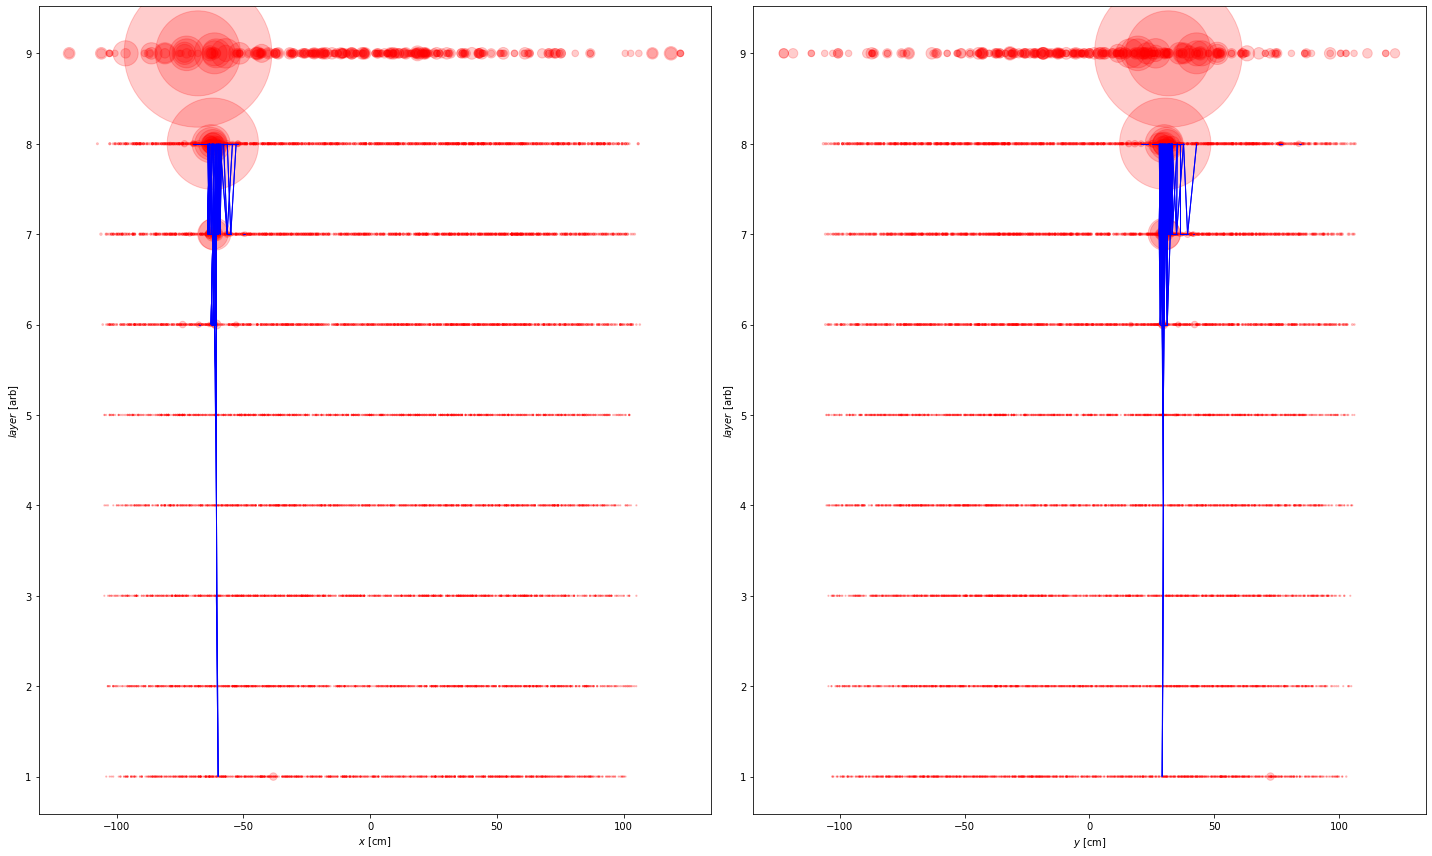

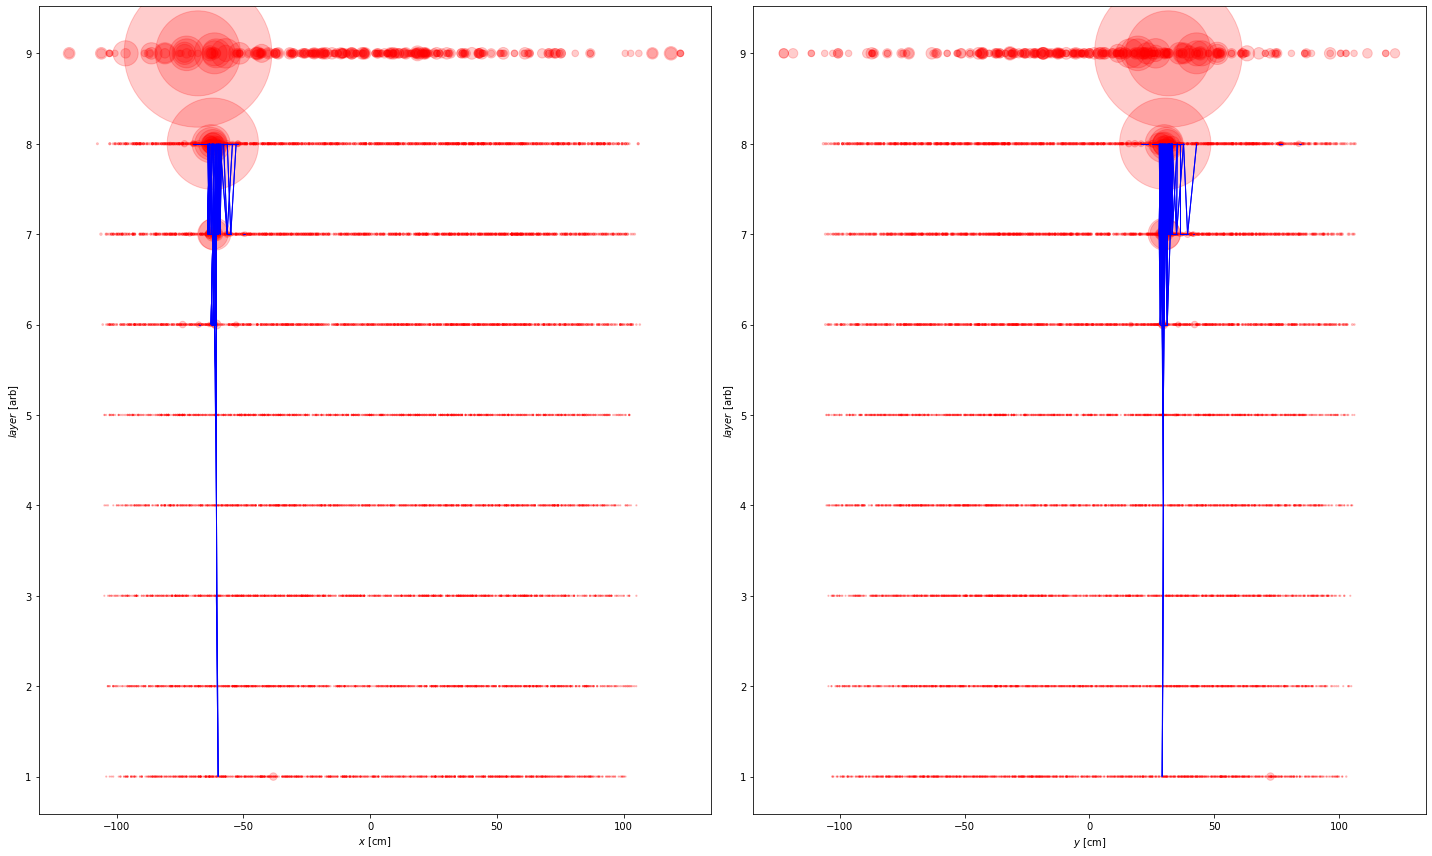

In [11]:
draw_sample(X, Ri, Ro, y, y)

100%|██████████| 554/554 [00:00<00:00, 381927.09it/s]

(554, 5)


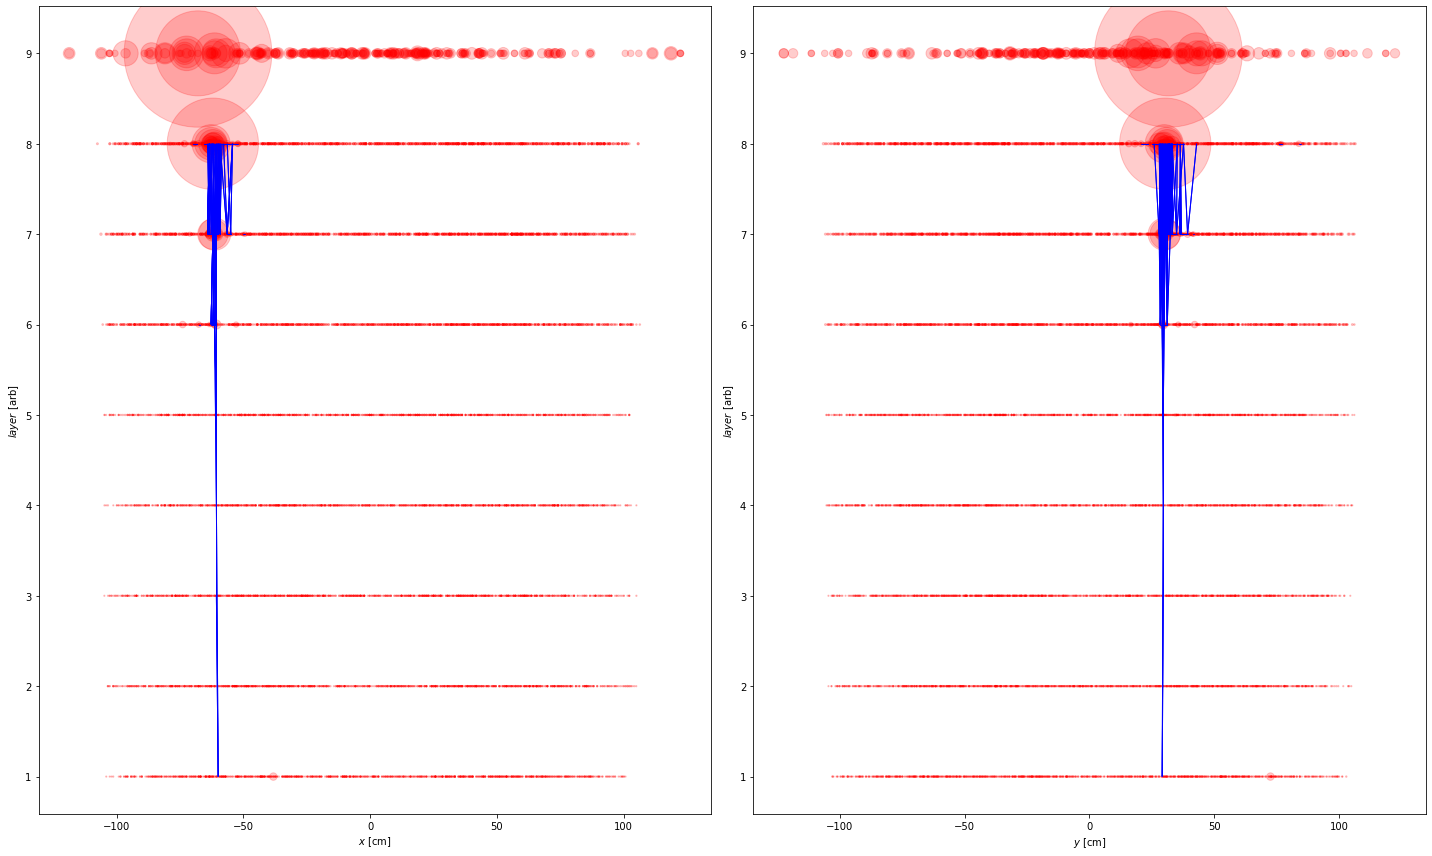

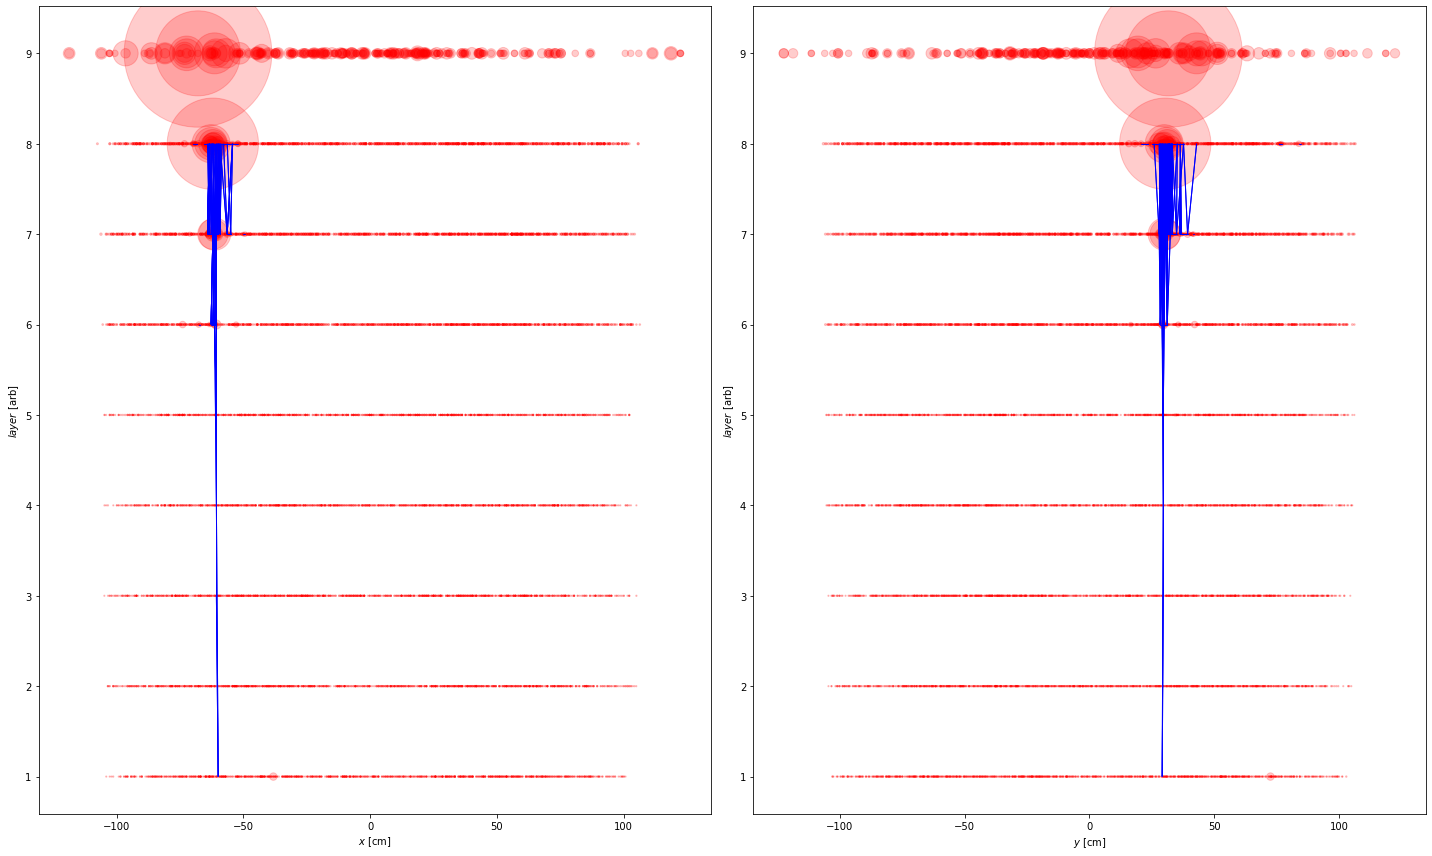

In [12]:
draw_sample(X, Ri, Ro, y, out)

In [13]:
def draw_sample(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
#    out_mask = (out >0.5) & (y > 0.5) ### only the correctly predicted signal edges
#    out_mask = (out >0.5) & (y < 0.5) ### only the incorrectly predicted signal edges
#    out_mask =  (y > 0.5) & (out <0.5)  ### signal incorrectly predicted as background
    out_mask =  (y < 0.5) & (out >0.5)  ### background incorrectly predicted as signal
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
#    print('out value:',out)
#    print('good_outs:',good_outs)
#    X[:,2]=X[:,2]*150.0
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]  
    
    print(feats_o.shape)
    # Prepare the figure
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
    cmap = plt.get_cmap(cmap)
    
#    print(X[:,0])
#    print(X[:,1])
    #print(X[:,2]*150.0)
#    print(X[:,4])
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    e_max = np.max(X[:,4])
#    e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_normed = 100*X[:,4]
    ax0.scatter(X[:,0], X[:,2], s=(e_normed), c='r',alpha=0.2)
    ax1.scatter(X[:,1], X[:,2], s=(e_normed), c='r',alpha=0.2)
    
    
    
       
    lines0 = []
    lines1 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm.tqdm(range(good_outs.shape[0])):
            
            lines0.append([(feats_o[j,0], feats_o[j,2]),(feats_i[j,0], feats_i[j,2])])
            lines1.append([(feats_o[j,1], feats_o[j,2]),(feats_i[j,1], feats_i[j,2])])
#            colors.append(color_map[good_outs[j]])
            colors.append(color_map[1])
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([feats_o[j,0], feats_i[j,0]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            ax1.plot([feats_o[j,1], feats_i[j,1]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    ax1.add_collection(lc1)
    
    # Adjust axes
    ax0.set_xlabel('$x$ [cm]')
    ax1.set_xlabel('$y$ [cm]')
    ax0.set_ylabel('$layer$ [arb]')
    ax1.set_ylabel('$layer$ [arb]')
    plt.tight_layout()
    return fig;
    

100%|██████████| 10/10 [00:00<00:00, 51845.54it/s]

(10, 5)


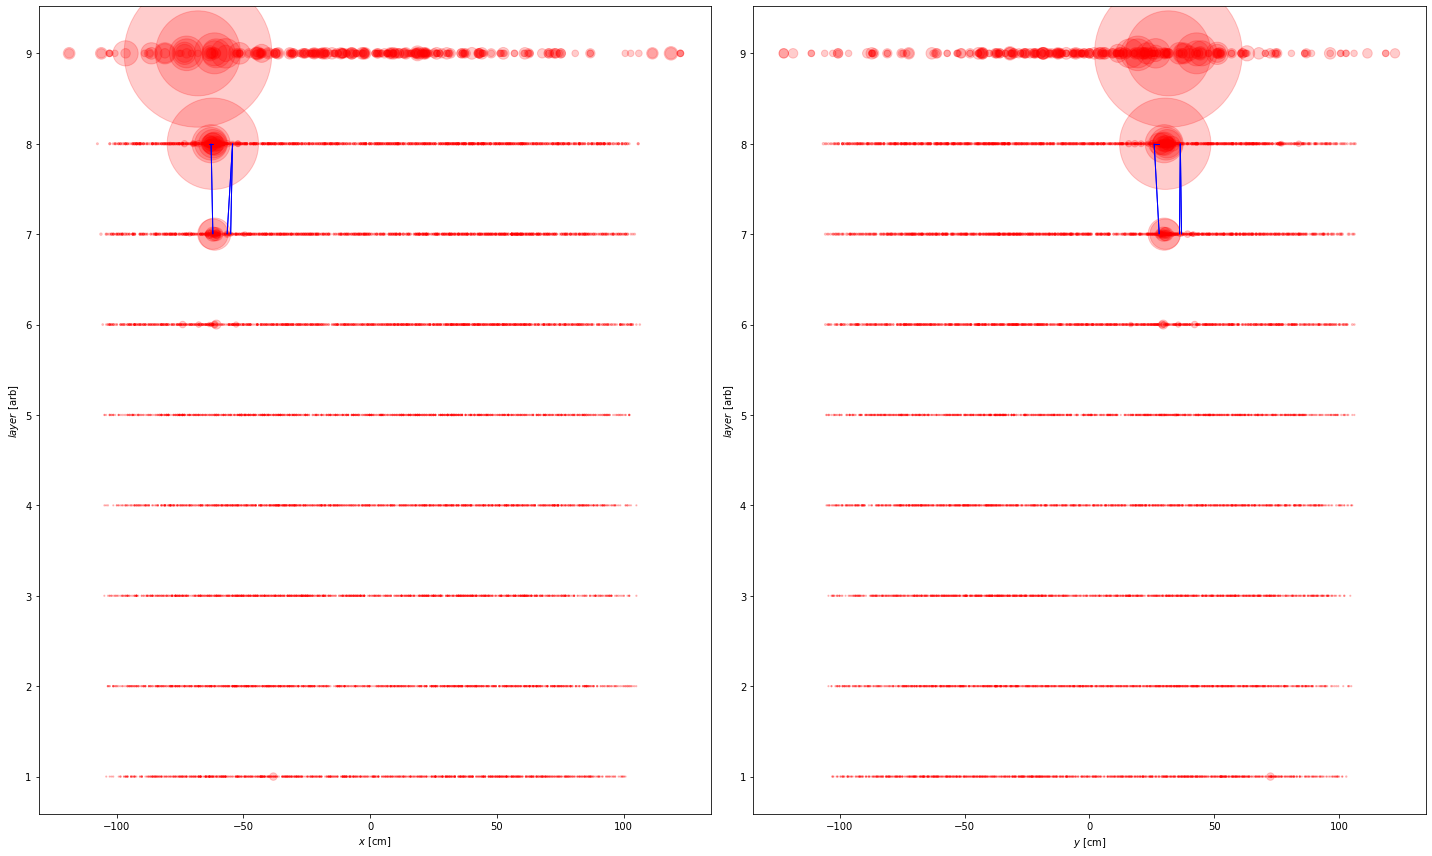

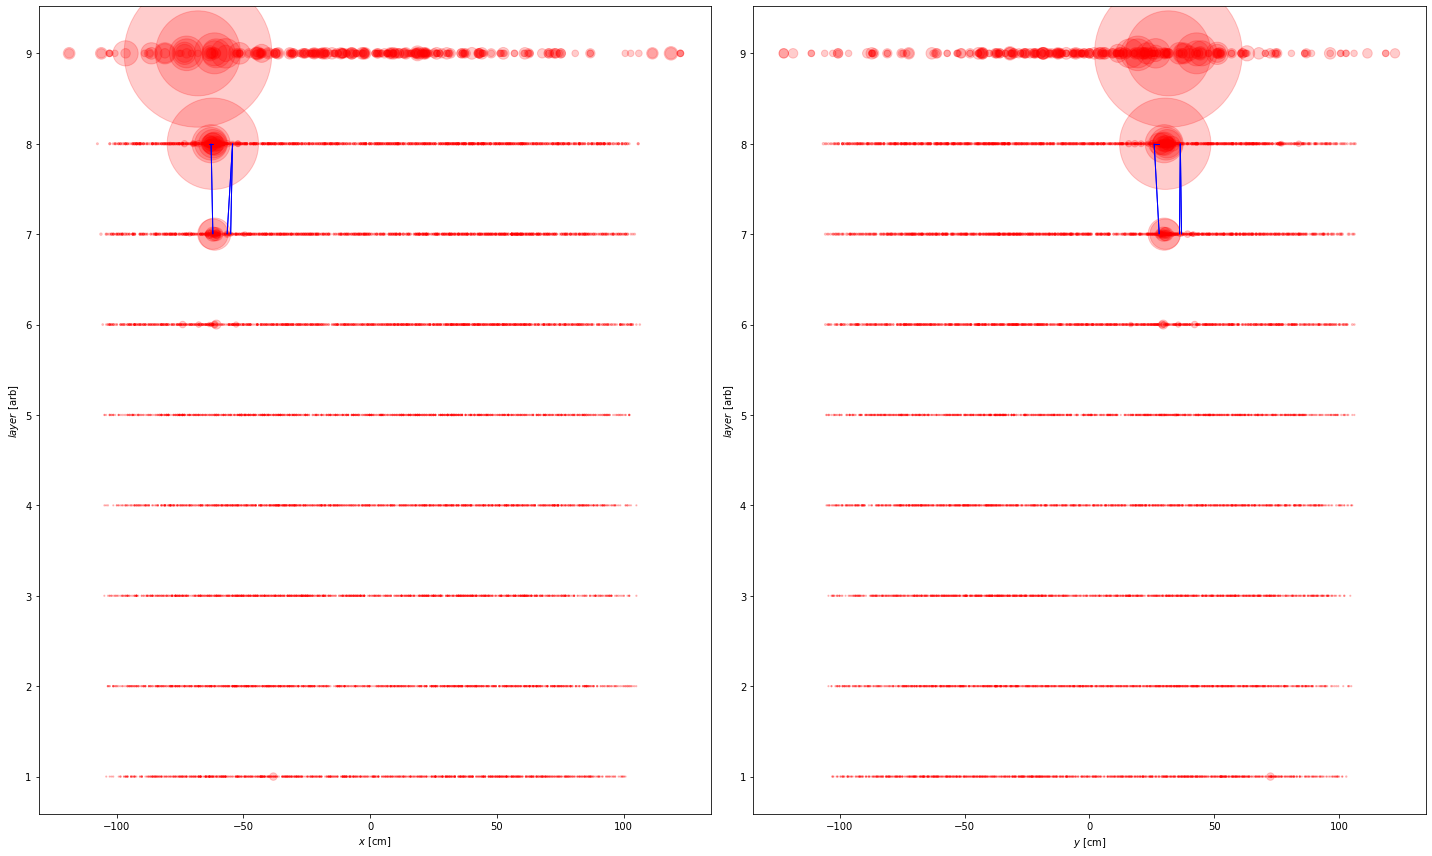

In [14]:
draw_sample(X, Ri, Ro, y, out)

In [15]:
datas = torch.load(test_fname)

In [16]:
datas

Data(edge_index=[2, 62520], x=[10140, 5], y=[62520])

In [17]:
datas.x

tensor([[-4.0897e+01, -2.8196e+00,  1.0000e+00, -1.0000e+00,  1.7270e-02],
        [-4.0200e+01, -3.2224e+00,  1.0000e+00, -1.0000e+00,  1.9737e-02],
        [-3.4618e+01, -8.8616e+00,  1.0000e+00, -1.0000e+00,  1.9737e-02],
        ...,
        [-1.1134e+01, -9.3425e+00,  9.0000e+00,  0.0000e+00, -4.8065e-01],
        [-1.3658e+01, -4.9711e+00,  9.0000e+00,  0.0000e+00, -2.6100e-02],
        [-1.4534e+01,  2.5413e-06,  9.0000e+00,  0.0000e+00, -9.3519e-01]])

In [18]:
X = datas.x.detach().numpy()

In [19]:
X.shape

(10140, 5)